In [4]:
import pandas as pd
import scipy.stats
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os
import math

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import plotly.express as pl
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf


import torch.optim
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler

# Machine learning libraries
import math
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPRegressor

import neuralsens.partial_derivatives as ns

In [5]:
cwd = os.getcwd()

data = pd.read_csv(cwd + '/datos_TFM_Celia.csv', sep = ',', engine='python')
data['Time'] = pd.to_datetime(data['Time'])

data['ws_lag1'] = data['ws'].shift(1)
data['ws_lag2'] = data['ws'].shift(2)
data['ws_lead1'] = data['ws'].shift(-1)
data['ws_lead2'] = data['ws'].shift(-2)
data['Power_lag1'] = data['Power'].shift(1)
data['Power_lag2'] = data['Power'].shift(2)
data.dropna(inplace=True)

df_hist = data[data['Time'] < "2013-01-01 01:00:00"]
df_fut = data[data['Time'] > "2013-01-01 00:00:00"]

In [6]:
horizon = 10
horizons = range(1, horizon+1)

# Naive

In [7]:
df_fut.index = df_fut['Time']

real_data = df_fut['Power'].values
predictions_list = []

for i in range(len(real_data)):
    last_real_value = real_data[i] if i < len(real_data) - 1 else real_data[-1]
    predictions = {h: last_real_value for h in horizons}
    predictions_list.append(predictions)

predictions_matrix_naive = pd.DataFrame(predictions_list)
predictions_matrix_naive.index = df_fut['Time'].values

naive_predictions_matrix = pd.DataFrame()
for i in range(horizon):
    shifted_predictions = predictions_matrix_naive.iloc[:, i].shift(i+1)
    naive_predictions_matrix[f'+{i+1}h'] = shifted_predictions

naive_predictions_matrix.index = df_fut['Time'].values
naive_predictions_matrix['Power'] = df_fut['Power']

# MLP Recursivo

In [38]:
INPUTS = ['ws', 'wd', 'ws_lag1', 'ws_lag2', 'Power_lag1', 'Power_lag2', 'ws_lead1', 'ws_lead2']
OUTPUT = 'Power'

X = df_hist[INPUTS]
y = df_hist[OUTPUT]

X_train = X.iloc[0:round(0.8*X.shape[0])]
X_test = X.iloc[round(0.8*X.shape[0])+1:X.shape[0]]
y_train = y.iloc[0:round(0.8*X.shape[0])]
y_test = y.iloc[round(0.8*X.shape[0])+1:X.shape[0]]

## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['Power'] = y_train

dfTS_eval = X_test.copy()
dfTS_eval['Power'] = y_test

In [17]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, INPUTS)])

param = {'MLP__alpha': [0.0001,0.001,0.01], # Initial value of regularization
        'MLP__hidden_layer_sizes': [
        #(5,),  # Single layer with 5 neurons
        #(10,),  # Single layer with 10 neurons
        #(50,),  # Single layer with 50 neurons
        #(100,),  # Single layer with 100 neurons
        (5, 5),  # Two layers, each with 5 neurons
        (10, 10),  # Two layers, each with 10 neurons
        (50, 50),  # Two layers, each with 50 neurons
        (100, 50),  # Two layers, first with 100 neurons, second with 50 neurons
        (50, 50, 50),  # Three layers, each with 50 neurons
        (100, 100, 50),  # Three layers, first two with 100 neurons, third with 50 neurons
        (100, 100, 100),  # Three layers, each with 100 neurons
        (50, 50, 50, 50),  # Four layers, each with 50 neurons
        (100, 100, 50, 50)  # Four layers, first two with 100 neurons, last two with 50 neurons
        ]
}

pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('MLP', MLPRegressor(solver='lbfgs',
                activation='logistic', 
                max_iter=450, 
                tol=1e-4, 
                random_state=150,
                verbose = False))]) 

# Grid Search Cross Validation
nFolds = 10
MLP_fit_1 = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='neg_mean_squared_error', 
                       cv=nFolds)
MLP_fit_1.fit(X_train[INPUTS], y_train) # Search in grid


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['ws',
                                                                          'wd',
                                                                          'ws_lag1',
                                                                          'ws_lag2',
                                                                          'Power_lag1',
                                                                          'Power_lag2',
                                                                          'ws_lead1',
                                                                          'ws_lead2'])])),
                                       ('MLP',
                                        MLPRegressor(activation='logistic',
                                                     max_iter=450,
                                                     random_state=150,
                                                     solver='lbfgs'))]),
             n_jobs=-1,
             param_grid={'MLP__alpha': [0.0001, 0.001, 0.01],
                         'MLP__hidden_layer_sizes': [(5, 5), (10, 10), (50, 50),
                                                     (100, 50), (50, 50, 50),
                                                     (100, 100, 50),
                                                     (100, 100, 100),
                                                     (50, 50, 50, 50),
                                                     (100, 100, 50, 50)]},
             scoring='neg_mean_squared_error')

In [18]:
MLP_fit_1.best_params_

{'MLP__alpha': 0.01, 'MLP__hidden_layer_sizes': (50, 50)}

In [19]:
best_mlp_model = MLP_fit_1.best_estimator_.named_steps['MLP']
coefs = best_mlp_model.coefs_
intercepts = best_mlp_model.intercepts_
num_params = sum([layer.size for layer in coefs]) + sum([layer.size for layer in intercepts])

print("Número de parámetros ajustados (pesos de la red):", num_params)



Número de parámetros ajustados (pesos de la red): 3051


In [ ]:
mlp = MLP_fit_1.best_estimator_['MLP']
wts = mlp.coefs_
bias = mlp.intercepts_

actfunc = ['identity'] + \
           len(MLP_fit_1.best_estimator_['MLP'].get_params()['hidden_layer_sizes']) * [MLP_fit_1.best_estimator_['MLP'].get_params()['activation']] + \
           [mlp.out_activation_]

X = MLP_fit_1.best_estimator_['preprocessor'].transform(X_train) # Preprocess the variables

coefnames = INPUTS

X = pd.DataFrame(X, columns=coefnames)
y = pd.DataFrame(y_train, columns=['Y'])
sens_end_layer = 'last'
sens_end_input = False
sens_origin_layer = 0
sens_origin_input = True

sensmlp = ns.jacobian_mlp(wts, bias, actfunc, X, y)

In [ ]:
sensmlp.plot()

In [39]:
# Realizar predicciones con el modelo entrenado
y_train_pred = MLP_fit_1.predict(X_train[INPUTS])
y_test_pred = MLP_fit_1.predict(X_test[INPUTS])

# Calcular métricas de rendimiento
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_rmse = math.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = math.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print('Training MAE:', train_mae)
print('Test MAE:', test_mae)
print('Training RMSE:', train_rmse)
print('Test RMSE:', test_rmse)
print('Training R2:', train_r2)
print('Test R2:', test_r2)


Training MAE: 0.06034835191927883
Test MAE: 0.06343432852111701
Training RMSE: 0.08998776428732115
Test RMSE: 0.09603758702945467
Training R2: 0.906621087125156
Test R2: 0.8592855493747078


In [40]:
df_forecast = df_fut.copy()
df_forecast = df_forecast.reset_index(drop=True)

for i in range(1, horizon + 1):
    df_forecast[f'Power_forecast_{i}'] = np.nan

for i in range(len(df_forecast) - horizon):
    df_local = df_forecast.copy()
    for j in range(0, horizon):
        current_features = df_local.iloc[[i+j]][INPUTS]
        current_prediction = MLP_fit_1.predict(current_features)[0] #make predictions
        
        if i + j < len(df_forecast):
            df_forecast.at[i, f'Power_forecast_{j+1}'] = current_prediction #store prediction

        # Prepare features for next prediction
        if j < horizon and i + j + 1 < len(df_forecast):
            # Update the features for the next horizon with the current prediction
            df_local.at[i + j + 1, 'Power_lag2'] = df_local.at[i + j, 'Power_lag1']
            df_local.at[i + j + 1, 'Power_lag1'] = current_prediction

df_forecast_1 = df_forecast.dropna(subset=[f'Power_forecast_{i}' for i in range(1, horizon + 1)])

In [41]:
df_MLP_rec = df_forecast_1.copy()
df_MLP_rec.index = df_MLP_rec['Time']
df_MLP_rec = df_MLP_rec.drop(columns=INPUTS)
df_MLP_rec = df_MLP_rec.drop(columns=['Time'])

MLP_predictions_matrix_rec = pd.DataFrame()
MLP_predictions_matrix_rec['Power'] = df_MLP_rec['Power']
df_MLP_res_v2 = df_MLP_rec.drop(columns=['Power'])
for i in range(horizon):
    shifted_predictions = df_MLP_res_v2.iloc[:, i].shift(i)
    MLP_predictions_matrix_rec[f'+{1+i}h'] = shifted_predictions

MLP_predictions_matrix_rec = MLP_predictions_matrix_rec.dropna()
MLP_predictions_matrix_rec

,Power,+1h,+2h,+3h,+4h,+5h,+6h,+7h,+8h,+9h,+10h
Time,,,,,,,,,,,
2013-01-01 10:00:00,0.146133,0.199608,0.248228,0.195467,0.271257,0.269680,0.291874,0.294356,0.297779,0.301137,0.305778
2013-01-01 11:00:00,0.191523,0.141056,0.194145,0.236214,0.191819,0.255453,0.254116,0.272963,0.275076,0.277992,0.280854
2013-01-01 12:00:00,0.164646,0.187699,0.137639,0.182712,0.218016,0.180977,0.234163,0.233036,0.248962,0.250752,0.253224
2013-01-01 13:00:00,0.205526,0.155899,0.178810,0.136355,0.173469,0.202805,0.172071,0.216308,0.215363,0.228744,0.230252
2013-01-01 14:00:00,0.115497,0.198026,0.148661,0.168096,0.133223,0.163499,0.187710,0.162357,0.198933,0.198146,0.209311
...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 02:00:00,0.049619,-0.005616,-0.041669,-0.051508,-0.058311,-0.064238,-0.064565,-0.063923,-0.063621,-0.062983,-0.062704
2013-12-31 03:00:00,0.065783,0.027772,-0.021645,-0.047927,-0.054708,-0.059316,-0.063301,-0.063520,-0.063090,-0.062887,-0.062460
2013-12-31 04:00:00,0.110046,0.041880,0.007594,-0.028848,-0.047024,-0.051606,-0.054696,-0.057357,-0.057503,-0.057216,-0.057081


# MLP Directo

In [8]:
data_dir = data.copy()

for i in range(1, horizon + 1):
    data_dir[f'Power_lead{i}'] = data_dir['Power'].shift(-i)

for i in range(1, horizon + 3):
    data_dir[f'ws_lead{i}'] = data_dir['ws'].shift(-i)

data_dir = data_dir.dropna()

df_hist_dir = data_dir[data_dir['Time'] < "2013-01-01 01:00:00"]
df_fut_dir = data_dir[data_dir['Time'] > "2013-01-01 00:00:00"]

In [21]:
INPUTS_dir = ['ws','wd', 'ws_lag1', 'ws_lag2', 'Power_lag1', 'Power_lag2'] + [f'ws_lead{i}' for i in range(1, horizon + 3)]
OUTPUTS_dir = ['Power'] + [f'Power_lead{i}' for i in range(1, horizon)] #tenemos 10 outputs

X = df_hist_dir[INPUTS_dir]
y = df_hist_dir[OUTPUTS_dir]

X_train = X.iloc[0:round(0.8*X.shape[0])]
X_test = X.iloc[round(0.8*X.shape[0])+1:X.shape[0]]
y_train = y.iloc[0:round(0.8*X.shape[0])]
y_test = y.iloc[round(0.8*X.shape[0])+1:X.shape[0]]

## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTS_eval = X_test.copy()
dfTR_eval['Power'] = y_train['Power']
dfTS_eval['Power'] = y_test['Power']

for i in range(1, horizon):
    dfTR_eval[f'Power_lead{i}'] = y_train[f'Power_lead{i}'].shift(-i) if f'Power_lead{i}' in y_train else np.nan
    dfTS_eval[f'Power_lead{i}'] = y_test[f'Power_lead{i}'].shift(-i) if f'Power_lead{i}' in y_test else np.nan

In [11]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, INPUTS_dir)])

param = {'MLP__alpha': [0.0001,0.001,0.01], # Initial value of regularization
        'MLP__hidden_layer_sizes':[(5,),(50,),(10,10),(50,50),(50,50,50)]} # Number of neurons in each hidden layer, enters as tuples

pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('MLP', MLPRegressor(solver='lbfgs',
                activation='logistic', 
                max_iter=450, 
                tol=1e-4, 
                random_state=150,
                verbose = False))]) 

nFolds = 10
MLP_fit_2 = GridSearchCV(estimator=pipe, 
                       param_grid=param, 
                       n_jobs=-1, 
                       scoring='neg_mean_squared_error', 
                       cv=nFolds) 

MLP_fit_2.fit(X_train[INPUTS_dir], y_train) 

/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['ws',
                                                                          'wd',
                                                                          'ws_lag1',
                                                                          'ws_lag2',
                                                                          'Power_lag1',
                                                                          'Power_lag2',
                                                                          'ws_lead1',
                                                                          'ws_lead2',
                                                                          'ws_lead3',
                                                                          'ws_lead4',
                                                                          'ws_lead5',
                                                                          'ws_lead6',
                                                                          'ws_lead7',
                                                                          'ws_lead8',
                                                                          'ws_lead9',
                                                                          'ws_lead10',
                                                                          'ws_lead11',
                                                                          'ws_lead12'])])),
                                       ('MLP',
                                        MLPRegressor(activation='logistic',
                                                     max_iter=450,
                                                     random_state=150,
                                                     solver='lbfgs'))]),
             n_jobs=-1,
             param_grid={'MLP__alpha': [0.0001, 0.001, 0.01],
                         'MLP__hidden_layer_sizes': [(5,), (50,), (10, 10),
                                                     (50, 50), (50, 50, 50)]},
             scoring='neg_mean_squared_error')

In [12]:
MLP_fit_2.best_params_

{'MLP__alpha': 0.0001, 'MLP__hidden_layer_sizes': (50, 50)}

In [28]:
best_mlp_model = MLP_fit_2.best_estimator_.named_steps['MLP']
coefs = best_mlp_model.coefs_
intercepts = best_mlp_model.intercepts_
num_params = sum([layer.size for layer in coefs]) + sum([layer.size for layer in intercepts])

print("Número de parámetros ajustados (pesos de la red):", num_params)



Número de parámetros ajustados (pesos de la red): 4010


In [22]:
# Realizar predicciones con el modelo entrenado
y_train_pred = MLP_fit_2.predict(X_train[INPUTS_dir])
y_test_pred = MLP_fit_2.predict(X_test[INPUTS_dir])

# Calcular métricas de rendimiento
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_rmse = math.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = math.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print('Training MAE:', train_mae)
print('Test MAE:', test_mae)
print('Training RMSE:', train_rmse)
print('Test RMSE:', test_rmse)
print('Training R2:', train_r2)
print('Test R2:', test_r2)

Training MAE: 0.10342732439051476
Test MAE: 0.1094104590205797
Training RMSE: 0.14669063043854252
Test RMSE: 0.1551749140849486
Training R2: 0.7518756822865917
Test R2: 0.63261029609214


In [23]:
X_current = df_fut_dir[INPUTS_dir]
predictions = MLP_fit_2.predict(X_current)

new_column_names = ['MLP_Power'] + [f'MLP_Power_lead{i}' for i in range(1, horizon)]
predictions_df = pd.DataFrame(predictions, columns=new_column_names)
predictions_df.index = df_fut_dir['Time']

In [32]:
# Calcular la correlación entre cada característica de entrada y las predicciones
correlations = {}
for column in INPUTS_dir:
    correlation = np.corrcoef(X_current[column], predictions_df['MLP_Power'])[0, 1]
    correlations[column] = correlation

print("Importancia de cada característica para 'MLP_Power':")
for feature, importance in sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True):
    print(f"{feature}: {importance}")
for i in range(1, horizon):
    column_name = f'MLP_Power_lead{i}'
    print(f"\nImportancia de cada característica para '{column_name}':")
    for feature, importance in sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True):
        print(f"{feature}: {np.corrcoef(X_current[feature], predictions_df[column_name])[0, 1]}")

Importancia de cada característica para 'MLP_Power':
Power_lag1: 0.9897447505010385
Power_lag2: 0.9218653338001225
ws_lead1: 0.7893936408731721
ws: 0.7857875495265881
ws_lead2: 0.7824679078400143
ws_lag1: 0.7733070706521292
ws_lead3: 0.7672163784290705
ws_lead4: 0.7514944131405589
ws_lag2: 0.7513829786317905
ws_lead5: 0.7292092242933677
ws_lead6: 0.6986318313524853
ws_lead7: 0.665816770111304
ws_lead8: 0.6315011029636657
ws_lead9: 0.5963414855517633
ws_lead10: 0.5609137259432218
ws_lead11: 0.5236389461044386
ws_lead12: 0.488420452512396
wd: -0.00957254623079123

Importancia de cada característica para 'MLP_Power_lead1':
Power_lag1: 0.9692484395248384
Power_lag2: 0.9032696379916285
ws_lead1: 0.8249806343946923
ws: 0.8140274469140076
ws_lead2: 0.8248084800241074
ws_lag1: 0.7941520196601404
ws_lead3: 0.8157518612601001
ws_lead4: 0.8043844462645049
ws_lag2: 0.7662556527087405
ws_lead5: 0.7864864261590754
ws_lead6: 0.7606911826311102
ws_lead7: 0.7320296360085187
ws_lead8: 0.700683535135627


In [24]:
MLP_predictions_matrix_dir = pd.DataFrame()

for i in range(horizon):
    shifted_predictions = predictions_df.iloc[:, i].shift(i)
    MLP_predictions_matrix_dir[f'+{1+i}h'] = shifted_predictions

MLP_predictions_matrix_dir.index = predictions_df.index
df_fut_dir.index = df_fut_dir['Time']
MLP_predictions_matrix_dir['Power'] = df_fut_dir['Power']
MLP_predictions_matrix_dir

,+1h,+2h,+3h,+4h,+5h,+6h,+7h,+8h,+9h,+10h,Power
Time,,,,,,,,,,,
2013-01-01 01:00:00,0.192116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.117376
2013-01-01 02:00:00,0.199000,0.216528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.137675
2013-01-01 03:00:00,0.207591,0.218506,0.248630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.160605
2013-01-01 04:00:00,0.220061,0.219675,0.248442,0.275078,NaN,NaN,NaN,NaN,NaN,NaN,0.192463
2013-01-01 05:00:00,0.230725,0.225119,0.242363,0.264197,0.294679,NaN,NaN,NaN,NaN,NaN,0.187388
...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 00:00:00,-0.008954,-0.000643,0.000239,0.009777,0.014035,0.015641,0.020120,0.020198,0.018586,0.022601,0.000000
2013-12-31 01:00:00,-0.007408,0.000463,0.000873,0.010405,0.019009,0.013837,0.019683,0.019469,0.020310,0.011026,0.017653
2013-12-31 02:00:00,0.013089,0.004714,0.002268,0.012287,0.020379,0.021174,0.020876,0.020565,0.022653,0.014380,0.049619


# Comparación

In [42]:
MLP_predictions_matrix_dir = MLP_predictions_matrix_dir.dropna()
naive_predictions_matrix = naive_predictions_matrix.dropna()
MLP_predictions_matrix_v1 = MLP_predictions_matrix_dir.drop(MLP_predictions_matrix_dir.index[0])

In [43]:
error_list = []

for i in range(1, horizon+1):
    column_name = f'+{i}h'
    mae_rec = mean_absolute_error(MLP_predictions_matrix_rec['Power'], MLP_predictions_matrix_rec[column_name])
    rmse_rec = math.sqrt(mean_squared_error(MLP_predictions_matrix_rec['Power'], MLP_predictions_matrix_rec[column_name]))

    mae_dir = mean_absolute_error(MLP_predictions_matrix_dir['Power'], MLP_predictions_matrix_dir[column_name])
    rmse_dir = math.sqrt(mean_squared_error(MLP_predictions_matrix_dir['Power'], MLP_predictions_matrix_dir[column_name]))
    
    mae_n = mean_absolute_error(naive_predictions_matrix['Power'], naive_predictions_matrix[column_name])
    rmse_n = math.sqrt(mean_squared_error(naive_predictions_matrix['Power'], naive_predictions_matrix[column_name]))

    error_list.append({'Horizon': i, 'MAE dir': mae_dir, 'MAE rec': mae_rec, 'MAE Naive': mae_n, 'RMSE dir': rmse_dir,  'RMSE rec': rmse_rec, 'RMSE Naive': rmse_n})

# Convertir la lista de diccionarios a DataFrame
df_comp_error = pd.DataFrame(error_list)

df_comp_error['MAE Best'] = df_comp_error.apply(lambda row: 'dir' if (row['MAE dir'] < row['MAE rec']) and (row['MAE dir'] < row['MAE Naive']) else ('rec' if (row['MAE rec'] < row['MAE Naive']) else 'Naive'), axis=1)
df_comp_error['RMSE Best'] = df_comp_error.apply(lambda row: 'dir' if (row['RMSE dir'] < row['RMSE rec']) and (row['RMSE dir'] < row['RMSE Naive']) else ('rec' if (row['RMSE rec'] < row['RMSE Naive']) else 'Naive'), axis=1)

df_comp_error

,Horizon,MAE dir,MAE rec,MAE Naive,RMSE dir,RMSE rec,RMSE Naive,MAE Best,RMSE Best
0,1,0.063152,0.062837,0.063030,0.093761,0.094159,0.098944,rec,dir
1,2,0.086298,0.091051,0.094301,0.124826,0.129052,0.142586,dir,dir
2,3,0.099767,0.108500,0.117331,0.141750,0.149025,0.173422,dir,dir
3,4,0.108896,0.120524,0.136733,0.151968,0.162118,0.198460,dir,dir
4,5,0.115501,0.128996,0.153619,0.159172,0.171118,0.219864,dir,dir
5,6,0.120165,0.134729,0.168775,0.164946,0.177445,0.238767,dir,dir
6,7,0.123351,0.138675,0.182018,0.168539,0.181564,0.254954,dir,dir
7,8,0.125677,0.141703,0.193584,0.171158,0.184577,0.269551,dir,dir
8,9,0.127742,0.143462,0.204361,0.173204,0.186547,0.282359,dir,dir
9,10,0.129884,0.144921,0.214518,0.174934,0.187869,0.293856,dir,dir


In [ ]:
# df_comp_error.to_csv('MLP_Resultados.csv', index=False)

In [45]:
horizonte_prediccion = 1
column_name = f'+{horizonte_prediccion}h'


df_resultados = pd.DataFrame()
df_resultados['Time'] = MLP_predictions_matrix_rec.iloc[1:-2].index
df_resultados['Producción Real'] = MLP_predictions_matrix_rec['Power'].iloc[1:-2].values
df_resultados['MLP Directo'] = MLP_predictions_matrix_dir[column_name].iloc[1:].values
df_resultados['MLP Recursivo'] = MLP_predictions_matrix_rec[column_name].iloc[1:-2].values
df_resultados['Naive'] = naive_predictions_matrix[column_name].iloc[:-12].values



fig = pl.line(df_resultados, x='Time', y=['Producción Real', 'MLP Directo', 'MLP Recursivo'])
fig.show()

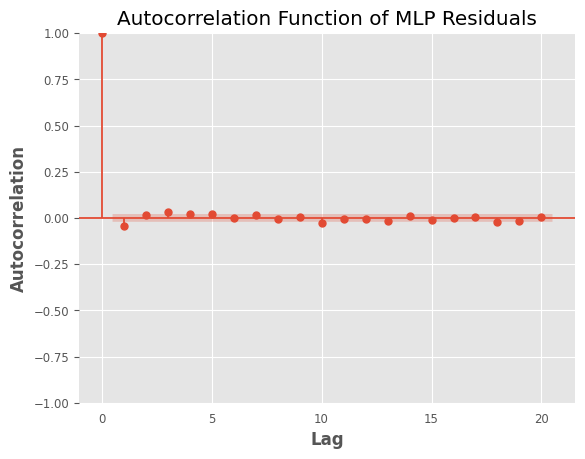

In [48]:
# Obtener residuos del modelo MLP
residuals = df_resultados['Producción Real'] - df_resultados['MLP Recursivo']

# Calcular la función de autocorrelación de los residuos
plot_acf(residuals, lags=20)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function of MLP Residuals')
plt.show()